# Practice: simple question answering
![img](https://www.cs.upc.edu/~mlatifi/index_files/qa-logo.jpg)

Today we're going to build a retrieval-based question answering model with metric learning models.

_this seminar is based on original notebook by [Oleg Vasilev](https://github.com/Omrigan/)_



In [1]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset

Today's data is Stanford Question Answering Dataset (SQuAD). Given a paragraph of text and a question, our model's task is to select a snippet that answers the question.

We are not going to solve the full task today. Instead, we'll train a model to __select the sentence containing answer__ among several options.

As usual, you are given an utility module with data reader and some helper functions

In [2]:
!pip install transformers
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week11_conversation/data.py -O data.py
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad-v2.0.json 2> log

import data
# backup download link: https://www.dropbox.com/s/q4fuihaerqr0itj/squad.tar.gz?dl=1
train, test = data.build_dataset('./squad-v2.0.json')

--2023-04-03 10:59:28--  https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week11_conversation/data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3553 (3.5K) [text/plain]
Saving to: ‘data.py’

data.py             100%[===================>]   3.47K  --.-KB/s    in 0s      

2023-04-03 10:59:28 (41.5 MB/s) - ‘data.py’ saved [3553/3553]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
pid, question, options, correct_indices, wrong_indices = train.iloc[40]
print('QUESTION', question, '\n')
for i, cand in enumerate(options):
    print(['[ ]', '[v]'][i in correct_indices], cand)

QUESTION Where did Beyonce get her name from? 

[ ] Beyoncé Giselle Knowles was born in Houston, Texas, to Celestine Ann "Tina" Knowles (née Beyincé), a hairdresser and salon owner, and Mathew Knowles, a Xerox sales manager.
[v] Beyoncé's name is a tribute to her mother's maiden name.
[ ] Beyoncé's younger sister Solange is also a singer and a former member of Destiny's Child.
[ ] Mathew is African-American, while Tina is of Louisiana Creole descent (with African, Native American, French, Cajun, and distant Irish and Spanish ancestry).
[ ] Through her mother, Beyoncé is a descendant of Acadian leader Joseph Broussard.
[ ] She was raised in a Methodist household.


### Pre-trained BERT
_(but you guessed it)_

We've already solved quite a few tasks from scratch, training our own embeddings and convolutional/recurrent layers. However, one can often achieve higher quality by using pre-trained models. We will default to the good ol' [BERT](https://arxiv.org/abs/1810.04805), though, you are free to use any [other model](https://huggingface.co/models) as you see fit.


In [4]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

In [5]:
from transformers import AutoTokenizer, AutoModel, pipeline

model_name = 'sentence-transformers/bert-base-nli-mean-tokens'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name).to(device)

In [6]:
# just a reminder: here's how it works
dummy_lines = [
    "How old are you?",                                                 # 0
    "In what mythology do two canines watch over the Chinvat Bridge?",  # 1
    "I'm sorry, okay, I'm not perfect, but I'm trying.",                # 2
    "What is your age?",                                                # 3
    "Beware, for I am fearless, and therefore powerful.",               # 4
]

with torch.no_grad():
    batch_tensors = tokenizer(dummy_lines, padding=True, truncation=True, return_tensors="pt")
    batch_tensors = {k: v.to(device) for k,v in batch_tensors.items()}
    token_embs, cls_embs = bert(**batch_tensors, return_dict=False)
    
    
mask = batch_tensors['attention_mask'][..., None].to(torch.float32)
naive_phrase_embs = (token_embs * mask).sum(1) / mask.sum(1)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


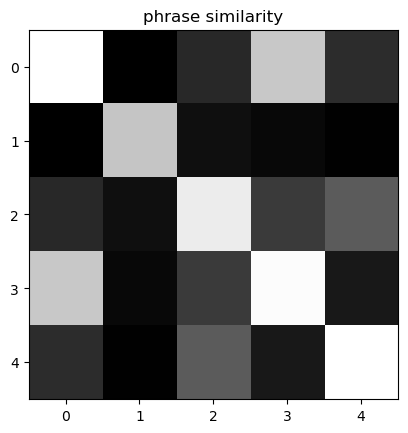

In [7]:
plt.title('phrase similarity')
plt.imshow((naive_phrase_embs @ naive_phrase_embs.t()).cpu().data.numpy(), interpolation='none', cmap='gray')

As you can see, __the strongest similarity is between lines 0 and 3__. Indeed they correspond to "How old are you?" and "What is your age?"

### Model (2 points)

Our goal for today is to build a model that measures similarity between question and answer. In particular, it maps both question and answer into fixed-size vectors such that:

Our model is a pair of $V_q(q)$ and $V_a(a)$ - networks that turn phrases into vectors. 

__Objective:__ Question vector $V_q(q)$ should be __closer__ to correct answer vectors $V_a(a^+)$ than to incorrect ones $V_a(a^-)$ .

Both vectorizers can be anything you wish. For starters, let's use a couple of dense layers on top of the pre-trained encoder.




In [8]:
class Vectorizer(nn.Module):
    def __init__(self, hid_size=256, bert=bert):
        """ A small feedforward network on top of pre-trained encoder. 2-3 layers should be enough """
        super().__init__()
        self.bert = bert
        self.hid_size = hid_size
        
        # define a few layers to be applied on top of pre-trained BERT
        # note: please make sure your final layer comes with _linear_ activation
        self.head = nn.Sequential(
            nn.Linear(bert.config.hidden_size, hid_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hid_size, hid_size),
        )
        

    def forward(self, input_phrases):
        """
        Apply vectorizer. Use dropout and any other hacks at will.
        :param input_phrases: a list of strings, [batch_size]
        :returns: predicted phrase vectors, [batch_size, output_size]
        
        Note: you may want to use dropouts.
        if self.training:
          <something>
        
        Note 2: you may also want to use with torch.no_grad to avoid training BERT for your first attempts
        
        """
        
        # In fact, please DO use at least 10% dropout!
        with torch.no_grad():
            batch_tensors = tokenizer(input_phrases, padding=True, truncation=True, return_tensors="pt")
            batch_tensors = {k: v.to(device) for k,v in batch_tensors.items()}
            token_embs, cls_embs = bert(**batch_tensors, return_dict=False)
            
        mask = batch_tensors['attention_mask'][..., None].to(torch.float32)
        phrase_embs = (token_embs * mask).sum(1) / mask.sum(1)
        return self.head(phrase_embs)

In [9]:
question_vectorizer = Vectorizer().to(device)
answer_vectorizer = Vectorizer().to(device)

In [10]:
question_vectorizer.train(False)
out1 = question_vectorizer(dummy_lines)
out2 = question_vectorizer(dummy_lines)
assert tuple(out1.shape) == (5, question_vectorizer.hid_size)
assert torch.allclose(out1, out2, atol=1e-5, rtol=0), "Make sure your model disables dropout if training == False"
print("Well done!")

Well done!


### Training: minibatches

Our model learns on triples $(q, a^+, a^-)$: 
* q - __q__uestion
* (a+) - correct __a__nswer
* (a-) - wrong __a__nswer 

Below you will find a generator that samples such triples from data.

In [11]:
import random

def iterate_minibatches(data, batch_size, shuffle=True, cycle=False):
    """
    Generates minibatches of triples: {questions, correct answers, wrong answers}
    If there are several wrong (or correct) answers, picks one at random.
    """
    indices = np.arange(len(data))
    while True:
        if shuffle:
            indices = np.random.permutation(indices)
        for batch_start in range(0, len(indices), batch_size):
            batch_indices = indices[batch_start: batch_start + batch_size]
            batch = data.iloc[batch_indices]
            questions = batch['question'].values
            correct_answers = np.array([
                row['options'][random.choice(row['correct_indices'])]
                for i, row in batch.iterrows()
            ])
            wrong_answers = np.array([
                row['options'][random.choice(row['wrong_indices'])]
                for i, row in batch.iterrows()
            ])

            yield {
                'questions' : questions,
                'correct_answers': correct_answers,
                'wrong_answers': wrong_answers,
            }
        if not cycle:
            break

In [12]:
dummy_batch = next(iterate_minibatches(train.sample(3), 3))
print(dummy_batch)

{'questions': array(['What year did Rugby League start?',
       'What Latin word does "cardinal" come from?',
       'What may self-identification not correlate with precisely?'],
      dtype=object), 'correct_answers': array(['Rugby League has also seen a representative fixture between Lancashire and Yorkshire contested 89 times since its inception in 1895.',
       'The term cardinal at one time applied to any priest permanently assigned or incardinated to a church, or specifically to the senior priest of an important church, based on the Latin cardo (hinge), meaning "principal" or "chief".',
       'And there are differences between sex and gender; self-identification may not be correlated with biology perfectly.'],
      dtype='<U228'), 'wrong_answers': array(["The county was once the focal point for many of the sport's professional competitions including the Lancashire League competition which ran from 1895 to 1970, and the Lancashire County Cup which was abandoned in 1993.",
   

### Training: loss function (2 points)
We want our vectorizers to put correct answers closer to question vectors and incorrect answers farther away from them. One way to express this is to use is Pairwise Hinge Loss _(aka Triplet Loss)_. 

$$ L = \frac 1N \underset {q, a^+, a^-} \sum max(0, \space \delta - sim[V_q(q), V_a(a^+)] + sim[V_q(q), V_a(a^-)] )$$

, where
* sim[a, b] is some similarity function: dot product, cosine or negative distance
* δ - loss hyperparameter, e.g. δ=1.0. If sim[a, b] is linear in b, all δ > 0 are equivalent.


This reads as __Correct answers must be closer than the wrong ones by at least δ.__

![img](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/margin.png)
<center>_image: question vector is green, correct answers are blue, incorrect answers are red_</center>


Note: in effect, we train a Deep Semantic Similarity Model [DSSM](https://www.microsoft.com/en-us/research/project/dssm/). 

In [13]:
def similarity(a, b):
    """ Dot product as a similarity function """
    return torch.einsum('bc,bc->b', a, b)

def compute_loss(question_vectors, correct_answer_vectors, wrong_answer_vectors, delta=1.0):
    """ 
    Compute the triplet loss as per formula above.
    Use similarity function above for  sim[a, b]
    :param question_vectors: float32[batch_size, vector_size]
    :param correct_answer_vectors: float32[batch_size, vector_size]
    :param wrong_answer_vectors: float32[batch_size, vector_size]
    :returns: loss for every row in batch, float32[batch_size]
    Hint: you can compute max(0, *) using torch.relu :)
    """
    sim_positive = similarity(question_vectors, correct_answer_vectors)
    sim_negative = similarity(question_vectors, wrong_answer_vectors)
    return torch.relu(delta - sim_positive + sim_negative)

In [14]:
dummy_v1 = torch.tensor([[0.1, 0.2, -1], [-1.2, 0.6, 1.0]], dtype=torch.float32)
dummy_v2 = torch.tensor([[0.9, 2.1, -6.6], [0.1, 0.8, -2.2]], dtype=torch.float32)
dummy_v3 = torch.tensor([[-4.1, 0.1, 1.2], [0.3, -1, -2]], dtype=torch.float32)

assert np.allclose(similarity(dummy_v1, dummy_v2).data.numpy(), [7.11, -1.84])
assert np.allclose(compute_loss(dummy_v1, dummy_v2, dummy_v3, delta=5.0).data.numpy(), [0.0, 3.88])

Once loss is working, let's train our model by our usual means.

In [15]:
# we also compute recall: the rate at which a^+ is closer to q than a^-
def get_recall(questions, correct_answers, wrong_answers):

    v_questions = question_vectorizer(list(questions))
    v_correct = answer_vectorizer(list(correct_answers))
    v_incorrect = answer_vectorizer(list(wrong_answers))

    correct_is_closer = similarity(v_questions, v_correct) > similarity(v_questions, v_incorrect)
    
    return torch.mean(correct_is_closer.to(torch.float32)).item()

In [16]:
# make sure it works
get_recall(**dummy_batch)

0.6666666865348816

### Training loop

Just as we always do, we can now train DSSM on minibatches and periodically measure recall on validation data.


__Note 1:__ DSSM training may be very sensitive to the choice of batch size. Small batch size may decrease model quality.

__Note 2:__ here we use the same dataset as __"test set"__ and __"validation (dev) set"__. 

In any serious scientific experiment, those must be two separate sets. Validation is for hyperparameter tuning and test is for final eval only.


In [17]:
import pandas as pd
from IPython.display import clear_output
from tqdm import tqdm


# Initialize model, optimizers, anything else you want
question_vectorizer = Vectorizer().to(device)
answer_vectorizer = Vectorizer().to(device)

all_layers = nn.ModuleList([question_vectorizer, answer_vectorizer])
opt = torch.optim.Adam(all_layers.parameters())


ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
dev_batches = iterate_minibatches(test, batch_size=256, cycle=True)
loss_history = []
dev_recall_history = []

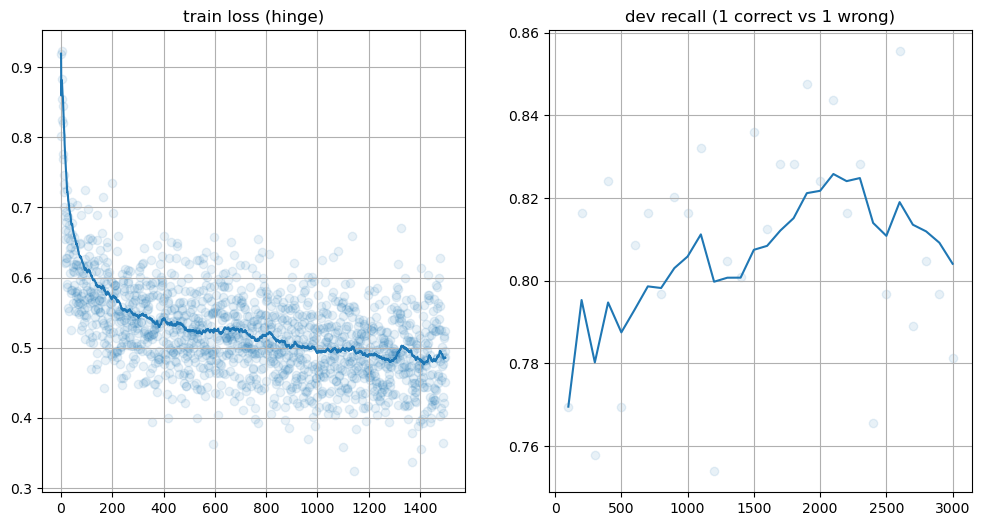

In [18]:
# infinite training loop. Stop it manually or implement early stopping

for batch in iterate_minibatches(train, batch_size=256, cycle=True):
    all_layers.train(True)
    
    # Perform one training step
    v_questions = question_vectorizer(list(batch['questions']))
    v_correct = answer_vectorizer(list(batch['correct_answers']))
    v_incorrect = answer_vectorizer(list(batch['wrong_answers']))
    
    
    loss_t = compute_loss(v_questions, v_correct, v_incorrect).mean()
    loss_t.backward()
    opt.step()
    opt.zero_grad()
    
    loss_history.append(float(loss_t))
    
    if len(loss_history) % 50 == 0:
        # measure dev recall = P(correct_is_closer_than_wrong | q, a+, a-)
        dev_batch = next(dev_batches)
        
        all_layers.train(False)
        recall_t = get_recall(**dev_batch)
        
        dev_recall_history.append(recall_t)
    
    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 100
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()
        
    if len(loss_history) >= 1500:
        break

In [19]:
print("Mean recall:", np.mean(dev_recall_history[-10:]))
assert np.mean(dev_recall_history[-10:]) > 0.8, "Please train for at least 82% recall on test set. "\
                                                  "You may need to change vectorizer model for that."
print("Well done!")

Mean recall: 0.8078125
Well done!


# Final evaluation (1 point)

Let's see how well does our model perform on actual question answering. 

Given a question and a set of possible answers, pick answer with highest similarity to estimate accuracy.

In [20]:
all_layers.train(False)

def select_best_answer(question, possible_answers):
    """
    Predicts which answer best fits the question
    :param question: a single string containing a question
    :param possible_answers: a list of strings containing possible answers
    :returns: integer - the index of best answer in possible_answer
    """
    with torch.no_grad():
        question_embed = question_vectorizer(question)
        answers_embed = answer_vectorizer(possible_answers)
    
    scored_answer_embed = []
    for i, answer_embed in enumerate(answers_embed):
        scored_answer_embed.append((similarity(question_embed, answer_embed.unsqueeze(0)), i))
        
    scored_answer_embed.sort(key=lambda x: x[0], reverse=True)
    
    return scored_answer_embed[0][1]
    

In [21]:
from tqdm.notebook import tqdm

predicted_answers = [
    select_best_answer(question, possible_answers)
    for i, (question, possible_answers) in tqdm(test[['question', 'options']].iterrows(), total=len(test))
]

accuracy = np.mean([
    answer in correct_ix
    for answer, correct_ix in zip(predicted_answers, test['correct_indices'].values)
])
print("Accuracy: %0.5f" % accuracy)
assert accuracy > 0.6, "we need more accuracy!"
print("Great job!")

  0%|          | 0/26970 [00:00<?, ?it/s]

Accuracy: 0.60056
Great job!


In [22]:
def draw_results(question, possible_answers, predicted_index, correct_indices):
    print("Q:", question, end='\n\n')
    for i, answer in enumerate(possible_answers):
        print("#%i: %s %s" % (i, '[*]' if i == predicted_index else '[ ]', answer))
    
    print("\nVerdict:", "CORRECT" if predicted_index in correct_indices else "INCORRECT", 
          "(ref: %s)" % correct_indices, end='\n' * 3)

In [23]:
for i in [1, 100, 1000, 2000, 3000, 4000, 5000]:
    draw_results(test.iloc[i].question, test.iloc[i].options,
                 predicted_answers[i], test.iloc[i].correct_indices)

Q: Which three countries did Beyonce's song "Work It Out" achieve top ten status?

#0: [*] In July 2002, Beyoncé continued her acting career playing Foxxy Cleopatra alongside Mike Myers in the comedy film, Austin Powers in Goldmember, which spent its first weekend atop the US box office and grossed $73 million.
#1: [ ] Beyoncé released "Work It Out" as the lead single from its soundtrack album which entered the top ten in the UK, Norway, and Belgium.
#2: [ ] In 2003, Beyoncé starred opposite Cuba Gooding, Jr., in the musical comedy The Fighting Temptations as Lilly, a single mother whom Gooding's character falls in love with.
#3: [ ] The film received mixed reviews from critics but grossed $30 million in the U.S. Beyoncé released "Fighting Temptation" as the lead single from the film's soundtrack album, with Missy Elliott, MC Lyte, and Free which was also used to promote the film.
#4: [ ] Another of Beyoncé's contributions to the soundtrack, "Summertime", fared better on the US charts.

In [24]:
question = "What is my name?" # your question here!
possible_answers = [
    'Your name is Satoshi Nakamoto',
    'London is the capital of Great Britain',
    'Your name was first mentioned in 1086',
    'Ivan is the founder of Tesla'
]
predicted_answer = select_best_answer(question, possible_answers)

draw_results(question, possible_answers,
             predicted_answer, [0])

Q: What is my name?

#0: [ ] Your name is Satoshi Nakamoto
#1: [ ] London is the capital of Great Britain
#2: [*] Your name was first mentioned in 1086
#3: [ ] Ivan is the founder of Tesla

Verdict: INCORRECT (ref: [0])


